# ===========================================================
# Solve the estimation problem with neural network tower model on the supervised dataset from the Jeopardy-like logs
# ===========================================================

Goals:
1. Split the data into test and train
2. Formulate the neural network based model
3. Compute train and test error

#### Last update: 05 Dec 2019

# Imports

In [18]:
from __future__ import division, print_function, absolute_import, unicode_literals

import scipy as sp
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import sys
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, LSTM, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras import regularizers

sys.path.insert(0, '../src/')
%matplotlib inline

import utils
from mytimer import Timer

# Parameters

In [19]:
data_fpath = '/home/omid/Datasets/Jeopardy/supervised_data.pk'
test_fraction = 0.2
runs = 30

# Helper functions

In [20]:
def compute_matrix_err(true_matrix: np.matrix, pred_matrix: np.matrix, type_str: str = 'frob_norm') -> float:
    if type_str == 'frob_norm':
        frob_norm_of_difference = np.linalg.norm(true_matrix - pred_matrix)
        err = frob_norm_of_difference / np.linalg.norm(true_matrix)
        return err
    elif type_str == 'corr':
#         (r, p) = sp.stats.spearmanr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        (r, p) = sp.stats.pearsonr(np.array(true_matrix.flatten())[0], np.array(pred_matrix.flatten())[0])
        if p > 0.05:
            r = 0
        return r
    else:
        raise ValueError('Wrong type_str was given.')

In [21]:
def get_eigvec_of_laplacian(A: np.matrix) -> np.matrix:
#     D = np.diag(np.array(np.sum(A, axis=0))[0])
#     L = D - A
#     return np.matrix(np.linalg.eig(L)[1])
    n, m = A.shape
    diags = A.sum(axis=1).flatten()
    D = sp.sparse.spdiags(diags, [0], m, n, format='csr')
    L = D - A
    with sp.errstate(divide='ignore'):
        diags_sqrt = 1.0/sp.sqrt(diags)
    diags_sqrt[sp.isinf(diags_sqrt)] = 0
    DH = sp.sparse.spdiags(diags_sqrt, [0], m, n, format='csr')
    DH = DH.todense()
    normalized_L = DH.dot(L.dot(DH))
    return normalized_L

In [ ]:
def my_init(shape, dtype=None):
    return np.ones(shape) * 0.25

# Loading the data

In [22]:
data = utils.load_it(data_fpath)
print(len(data['X']))

337


In [23]:
mats = []
for i in range(len(data['y'])):
    mats.append(data['y'][i]['influence_matrix'] / 100)

In [24]:
np.mean(mats, axis=0)

array([[0.26338279, 0.24830861, 0.25548961, 0.23243323],
       [0.2189911 , 0.33845697, 0.2158457 , 0.2227003 ],
       [0.21379822, 0.2511276 , 0.30367953, 0.22474777],
       [0.25338279, 0.24091988, 0.24379822, 0.26367953]])

In [25]:
np.std(mats, axis=0)

array([[0.12754406, 0.08032826, 0.09008641, 0.07827526],
       [0.10004831, 0.19647938, 0.08964129, 0.11201212],
       [0.09734972, 0.12308318, 0.17451618, 0.10372017],
       [0.0940633 , 0.06791981, 0.06305615, 0.09161002]])

# Formulating the tower model

## Only content embeddings

In [76]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []

    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']            
#             flatten_X_train.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_train.append(features['content_embedding_matrix'].flatten())
            flatten_y_train.append(np.array(label.flatten())[0] / 100)
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
#             flatten_X_test.append(np.array(features['reply_duration'].flatten())[0])
            flatten_X_test.append(features['content_embedding_matrix'].flatten())
            flatten_y_test.append(np.array(label.flatten())[0] / 100)
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)

        model = Sequential([
            Dense(32, kernel_initializer='he_normal', activation='relu', input_shape=(3072,)),
            Dropout(0.5),
            Dense(64, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
            Dense(32, kernel_initializer='he_normal', activation='relu'),
            Dropout(0.5),
#             Dense(16, kernel_initializer='he_normal', activation='softmax')])
            Dense(16, kernel_initializer=my_init, activation='softmax')])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
#         model = Sequential([
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 input_shape=(3072,),
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=64,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=32,
#                 kernel_initializer='he_normal',
#                 activation='relu',
#                 kernel_regularizer=regularizers.l1(lambda1)),
#             Dropout(0.5),
#             Dense(
#                 units=16,
#                 kernel_initializer='he_normal',
#                 activation='softmax',
#                 kernel_regularizer=regularizers.l1(lambda1))
#         ])
#         model.compile(optimizer='adam',
#                       loss='binary_crossentropy',
#                       metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)

        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix'] / 100

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7396 - accuracy: 0.0188
Epoch 2/10
269/269 [==============================] - 0s 106us/sample - loss: 0.7387 - accuracy: 0.0188
Epoch 3/10
269/269 [==============================] - 0s 107us/sample - loss: 0.7385 - accuracy: 0.0188
Epoch 4/10
269/269 [==============================] - 0s 97us/sample - loss: 0.7382 - accuracy: 0.0188
Epoch 5/10
269/269 [==============================] - 0s 91us/sample - loss: 0.7379 - accuracy: 0.0188
Epoch 6/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7377 - accuracy: 0.0188
Epoch 7/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7372 - accuracy: 0.0188
Epoch 8/10
269/269 [==============================] - 0s 78us/sample - loss: 0.7373 - accuracy: 0.0188
Epoch 9/10
269/269 [==============================] - 0s 78us/sample - loss: 0.7364 - accuracy: 0.0188
Epoch 10/10
269/269 [====================

269/269 [==============================] - 0s 67us/sample - loss: 0.7372 - accuracy: 0.0179
Epoch 9/10
269/269 [==============================] - 0s 67us/sample - loss: 0.7368 - accuracy: 0.0179
Epoch 10/10
269/269 [==============================] - 0s 70us/sample - loss: 0.7370 - accuracy: 0.0179
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7389 - accuracy: 0.0167
Epoch 2/10
269/269 [==============================] - 0s 95us/sample - loss: 0.7381 - accuracy: 0.0167
Epoch 3/10
269/269 [==============================] - 0s 96us/sample - loss: 0.7379 - accuracy: 0.0167
Epoch 4/10
269/269 [==============================] - 0s 69us/sample - loss: 0.7373 - accuracy: 0.0167
Epoch 5/10
269/269 [==============================] - 0s 74us/sample - loss: 0.7372 - accuracy: 0.0167
Epoch 6/10
269/269 [==============================] - 0s 87us/sample - loss: 0.7369 - accuracy: 0.0167
Epoch 7/10
269/269 [==============================] -

269/269 [==============================] - 0s 96us/sample - loss: 0.7365 - accuracy: 0.0193
Epoch 6/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7362 - accuracy: 0.0193
Epoch 7/10
269/269 [==============================] - 0s 76us/sample - loss: 0.7358 - accuracy: 0.0193
Epoch 8/10
269/269 [==============================] - 0s 74us/sample - loss: 0.7358 - accuracy: 0.0193
Epoch 9/10
269/269 [==============================] - 0s 66us/sample - loss: 0.7356 - accuracy: 0.0193
Epoch 10/10
269/269 [==============================] - 0s 69us/sample - loss: 0.7361 - accuracy: 0.0193
Run 16 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 2ms/sample - loss: 0.7391 - accuracy: 0.0167
Epoch 2/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7385 - accuracy: 0.0167
Epoch 3/10
269/269 [==============================] - 0s 83us/sample - loss: 0.7384 - accuracy: 0.0167
Epoch 4/10
269/269 [==============================] 

269/269 [==============================] - 0s 105us/sample - loss: 0.7378 - accuracy: 0.0156
Epoch 3/10
269/269 [==============================] - 0s 100us/sample - loss: 0.7376 - accuracy: 0.0156
Epoch 4/10
269/269 [==============================] - 0s 79us/sample - loss: 0.7377 - accuracy: 0.0156
Epoch 5/10
269/269 [==============================] - 0s 80us/sample - loss: 0.7370 - accuracy: 0.0156
Epoch 6/10
269/269 [==============================] - 0s 87us/sample - loss: 0.7371 - accuracy: 0.0156
Epoch 7/10
269/269 [==============================] - 0s 76us/sample - loss: 0.7368 - accuracy: 0.0156
Epoch 8/10
269/269 [==============================] - 0s 81us/sample - loss: 0.7364 - accuracy: 0.0156
Epoch 9/10
269/269 [==============================] - 0s 66us/sample - loss: 0.7363 - accuracy: 0.0156
Epoch 10/10
269/269 [==============================] - 0s 76us/sample - loss: 0.7361 - accuracy: 0.0156
Run 24 ...
Train on 269 samples
Epoch 1/10
269/269 [=============================

random: 0.6358637687891749 +- 0.017407726721425588
uniform: 0.3522141490130312 +- 0.018461737356623154
model: 0.34663943089383537 +- 0.016315834977931095


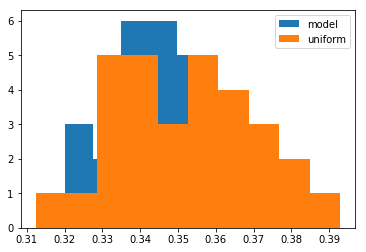

In [77]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

## Only networks

In [15]:
all_networks = True
one_type_network = 'reply_duration'   # 'emotion_dominance'
input_dim = 80
lambda1 = 1

In [16]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0] / 100)
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(np.array(features[one_type_network].flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0] / 100)
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim,),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=64,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=32,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(flatten_X_train, flatten_y_train, epochs=10, batch_size=32)
        predicted = model.predict(flatten_X_test)

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix'] / 100

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1129.2028 - accuracy: 0.0181
Epoch 2/10
269/269 [==============================] - 0s 110us/sample - loss: 1064.8313 - accuracy: 0.0181
Epoch 3/10
269/269 [==============================] - 0s 91us/sample - loss: 1003.3088 - accuracy: 0.0181
Epoch 4/10
269/269 [==============================] - 0s 71us/sample - loss: 944.0386 - accuracy: 0.0181
Epoch 5/10
269/269 [==============================] - 0s 74us/sample - loss: 888.0018 - accuracy: 0.0181
Epoch 6/10
269/269 [==============================] - 0s 76us/sample - loss: 834.2492 - accuracy: 0.0181
Epoch 7/10
269/269 [==============================] - 0s 75us/sample - loss: 782.8130 - accuracy: 0.0181
Epoch 8/10
269/269 [==============================] - 0s 65us/sample - loss: 733.7862 - accuracy: 0.0181
Epoch 9/10
269/269 [==============================] - 0s 69us/sample - loss: 686.8196 - accuracy: 0.0181
Epoch 10/10
269/269 [

269/269 [==============================] - 0s 75us/sample - loss: 862.4249 - accuracy: 0.0177
Epoch 7/10
269/269 [==============================] - 0s 58us/sample - loss: 810.4289 - accuracy: 0.0177
Epoch 8/10
269/269 [==============================] - 0s 57us/sample - loss: 760.2302 - accuracy: 0.0177
Epoch 9/10
269/269 [==============================] - 0s 56us/sample - loss: 712.5842 - accuracy: 0.0177
Epoch 10/10
269/269 [==============================] - 0s 59us/sample - loss: 667.2200 - accuracy: 0.0177
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1177.5967 - accuracy: 0.0165
Epoch 2/10
269/269 [==============================] - 0s 93us/sample - loss: 1112.2172 - accuracy: 0.0165
Epoch 3/10
269/269 [==============================] - 0s 91us/sample - loss: 1049.9725 - accuracy: 0.0165
Epoch 4/10
269/269 [==============================] - 0s 94us/sample - loss: 989.7653 - accuracy: 0.0165
Epoch 5/10
269/269 [============

269/269 [==============================] - 1s 3ms/sample - loss: 1135.1535 - accuracy: 0.0181
Epoch 2/10
269/269 [==============================] - 0s 95us/sample - loss: 1071.0275 - accuracy: 0.0181
Epoch 3/10
269/269 [==============================] - 0s 88us/sample - loss: 1008.8973 - accuracy: 0.0181
Epoch 4/10
269/269 [==============================] - 0s 79us/sample - loss: 949.9622 - accuracy: 0.0181
Epoch 5/10
269/269 [==============================] - 0s 68us/sample - loss: 892.7380 - accuracy: 0.0181
Epoch 6/10
269/269 [==============================] - 0s 73us/sample - loss: 838.4916 - accuracy: 0.0181
Epoch 7/10
269/269 [==============================] - 0s 65us/sample - loss: 786.4447 - accuracy: 0.0181
Epoch 8/10
269/269 [==============================] - 0s 65us/sample - loss: 736.9422 - accuracy: 0.0181
Epoch 9/10
269/269 [==============================] - 0s 62us/sample - loss: 689.7770 - accuracy: 0.0181
Epoch 10/10
269/269 [==============================] - 0s 65us/s

269/269 [==============================] - 0s 61us/sample - loss: 833.9246 - accuracy: 0.0193
Epoch 7/10
269/269 [==============================] - 0s 56us/sample - loss: 781.9596 - accuracy: 0.0193
Epoch 8/10
269/269 [==============================] - 0s 58us/sample - loss: 732.5152 - accuracy: 0.0193
Epoch 9/10
269/269 [==============================] - 0s 72us/sample - loss: 685.9425 - accuracy: 0.0193
Epoch 10/10
269/269 [==============================] - 0s 64us/sample - loss: 641.3913 - accuracy: 0.0193
Run 23 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 3ms/sample - loss: 1159.1377 - accuracy: 0.0160
Epoch 2/10
269/269 [==============================] - 0s 87us/sample - loss: 1093.9618 - accuracy: 0.0160
Epoch 3/10
269/269 [==============================] - 0s 83us/sample - loss: 1031.2505 - accuracy: 0.0160
Epoch 4/10
269/269 [==============================] - 0s 73us/sample - loss: 971.9063 - accuracy: 0.0160
Epoch 5/10
269/269 [===========

random: 0.6310301214868926 +- 0.01399059267030896
uniform: 0.34745737869634064 +- 0.017530337002096035
model: 0.34513695020571783 +- 0.016975889090539077


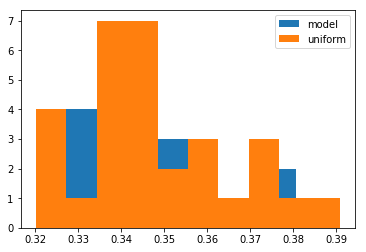

In [17]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));

# with Convolutional layers

In [12]:
all_networks = False
one_type_network = 'reply_duration'   # 'emotion_dominance'
input_dim = 16
lambda1 = 1

In [13]:
with Timer():

    model_errs = []
    random_errs = []
    uniform_errs = []
    for run in range(runs):
        print('Run', run, '...')
        X_train, X_test, y_train, y_test = train_test_split(
            data['X'], data['y'], test_size=test_fraction)

        flatten_X_train = []
        flatten_y_train = []
        for i in range(len(X_train)):
            features = X_train[i]
            label = y_train[i]['influence_matrix']
            if all_networks:
                flatten_X_train.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_train.append(
                    np.array(get_eigvec_of_laplacian(features[one_type_network]).flatten())[0])
            flatten_y_train.append(np.array(label.flatten())[0] / 100)
        flatten_X_train = np.array(flatten_X_train)
        flatten_y_train = np.array(flatten_y_train)

        flatten_X_test = []
        flatten_y_test = []
        for i in range(len(X_test)):
            features = X_test[i]
            label = y_test[i]['influence_matrix']
            if all_networks:
                flatten_X_test.append(np.hstack(
                    [np.array(features['reply_duration'].flatten())[0],
                     np.array(features['sentiment'].flatten())[0],
                     np.array(features['emotion_arousal'].flatten())[0],
                     np.array(features['emotion_dominance'].flatten())[0],
                     np.array(features['emotion_valence'].flatten())[0]]))
            else:
                flatten_X_test.append(
                    np.array(get_eigvec_of_laplacian(features[one_type_network]).flatten())[0])
            flatten_y_test.append(np.array(label.flatten())[0] / 100)
        flatten_X_test = np.array(flatten_X_test)
        flatten_y_test = np.array(flatten_y_test)
        
        model = Sequential([
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                input_shape=(input_dim, 1),
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                32,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            MaxPooling1D(2),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            Conv1D(
                64,
                2,
                kernel_initializer='he_normal',
                activation='relu',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1)),
            GlobalAveragePooling1D(),
            Dropout(0.5),
            Dense(
                units=16,
                kernel_initializer='he_normal',
                activation='softmax',
                kernel_regularizer=regularizers.l1(lambda1),
                activity_regularizer=regularizers.l1(lambda1))
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(
            np.reshape(flatten_X_train, (len(flatten_X_train), input_dim, 1)),
            flatten_y_train,
            epochs=10,
            batch_size=64)
        predicted = model.predict(np.reshape(flatten_X_test, (len(flatten_X_test), input_dim, 1)))

        model_err = 0
        uniform_err = 0
        random_err = 0
        for i in range(len(y_test)):
            real_influence_matrix = y_test[i]['influence_matrix'] / 100

            # Random model prediction:
            pred_random_influence_matrix = np.matrix(utils.make_matrix_row_stochastic(
                np.random.rand(4, 4)))
            random_err += compute_matrix_err(
                real_influence_matrix, pred_random_influence_matrix)

            # Uniform prediction:
            pred_uniform_influence_matrix = np.matrix(np.ones((4, 4)) * 0.25)
            uniform_err += compute_matrix_err(
                real_influence_matrix, pred_uniform_influence_matrix)

            # Model's prediction:
            predicted_influence_matrix = predicted[i]
            predicted_influence_matrix = utils.make_matrix_row_stochastic(
                np.matrix(np.reshape(predicted_influence_matrix, (4, 4))))
            model_err += compute_matrix_err(
                real_influence_matrix, predicted_influence_matrix)

        model_err /= len(y_test)
        uniform_err /= len(y_test)
        random_err /= len(y_test)

        model_errs.append(model_err)
        random_errs.append(random_err)
        uniform_errs.append(uniform_err)

Run 0 ...
Train on 269 samples
Epoch 1/10
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
269/269 [==============================] - 1s 5ms/sample - loss: 2316.7463 - accuracy: 0.0184
Epoch 2/10
269/269 [==============================] - 0s 91us/sample - loss: 2183.4574 - accuracy: 0.0184
Epoch 3/10
269/269 [==============================] - 0s 95us/sample - loss: 2074.5713 - accuracy: 0.0184
Epoch 4/10
269/269 [==============================] - 0s 73us/sample - loss: 1979.9266 - accuracy: 0.0184
Epoch 5/10
269/269 [==============================] - 0s 71us/sample - loss: 1894.4858 - accuracy: 0.0184
Epoch 6/10
269/269 [==============================] - 0s 73us/sample - loss: 1815.4952 - accuracy: 0.0184
Epoch 7/10
269/269 [==============================] - 0s 80us/sample - loss: 1741.3955 - accuracy: 0.0184
Epoch 8/10
269/269 [==============================] - 0s 65us/sample - loss: 1670.9995 - accuracy: 0.0184
Epoch 9/10
269/269 [========

269/269 [==============================] - 0s 70us/sample - loss: 2214.7773 - accuracy: 0.0179
Epoch 4/10
269/269 [==============================] - 0s 73us/sample - loss: 2104.7400 - accuracy: 0.0179
Epoch 5/10
269/269 [==============================] - 0s 71us/sample - loss: 2009.7255 - accuracy: 0.0179
Epoch 6/10
269/269 [==============================] - 0s 72us/sample - loss: 1925.4602 - accuracy: 0.0179
Epoch 7/10
269/269 [==============================] - 0s 65us/sample - loss: 1847.6449 - accuracy: 0.0179
Epoch 8/10
269/269 [==============================] - 0s 60us/sample - loss: 1774.8255 - accuracy: 0.0179
Epoch 9/10
269/269 [==============================] - 0s 63us/sample - loss: 1705.8209 - accuracy: 0.0179
Epoch 10/10
269/269 [==============================] - 0s 58us/sample - loss: 1640.4519 - accuracy: 0.0179
Run 8 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 4ms/sample - loss: 2438.2959 - accuracy: 0.0151
Epoch 2/10
269/269 [======

269/269 [==============================] - 0s 77us/sample - loss: 1715.8591 - accuracy: 0.0174
Epoch 9/10
269/269 [==============================] - 0s 84us/sample - loss: 1648.2367 - accuracy: 0.0174
Epoch 10/10
269/269 [==============================] - 0s 71us/sample - loss: 1583.3526 - accuracy: 0.0174
Run 15 ...
Train on 269 samples
Epoch 1/10
269/269 [==============================] - 1s 4ms/sample - loss: 2326.9215 - accuracy: 0.0181
Epoch 2/10
269/269 [==============================] - 0s 107us/sample - loss: 2192.6564 - accuracy: 0.0181
Epoch 3/10
269/269 [==============================] - 0s 101us/sample - loss: 2081.9460 - accuracy: 0.0181
Epoch 4/10
269/269 [==============================] - 0s 86us/sample - loss: 1986.5235 - accuracy: 0.0181
Epoch 5/10
269/269 [==============================] - 0s 76us/sample - loss: 1901.4864 - accuracy: 0.0181
Epoch 6/10
269/269 [==============================] - 0s 71us/sample - loss: 1823.1826 - accuracy: 0.0181
Epoch 7/10
269/269 [===

269/269 [==============================] - 0s 89us/sample - loss: 2358.6497 - accuracy: 0.0163
Epoch 3/10
269/269 [==============================] - 0s 83us/sample - loss: 2222.9291 - accuracy: 0.0163
Epoch 4/10
269/269 [==============================] - 0s 92us/sample - loss: 2113.3849 - accuracy: 0.0163
Epoch 5/10
269/269 [==============================] - 0s 84us/sample - loss: 2018.9774 - accuracy: 0.0163
Epoch 6/10
269/269 [==============================] - 0s 77us/sample - loss: 1935.2338 - accuracy: 0.0163
Epoch 7/10
269/269 [==============================] - 0s 70us/sample - loss: 1857.9612 - accuracy: 0.0163
Epoch 8/10
269/269 [==============================] - 0s 62us/sample - loss: 1786.2416 - accuracy: 0.0163
Epoch 9/10
269/269 [==============================] - 0s 63us/sample - loss: 1718.1422 - accuracy: 0.0163
Epoch 10/10
269/269 [==============================] - 0s 57us/sample - loss: 1653.1951 - accuracy: 0.0163
Run 23 ...
Train on 269 samples
Epoch 1/10
269/269 [====

269/269 [==============================] - 0s 78us/sample - loss: 1756.1120 - accuracy: 0.0184
Epoch 8/10
269/269 [==============================] - 0s 68us/sample - loss: 1687.1337 - accuracy: 0.0184
Epoch 9/10
269/269 [==============================] - 0s 66us/sample - loss: 1621.3016 - accuracy: 0.0184
Epoch 10/10
269/269 [==============================] - 0s 65us/sample - loss: 1558.1169 - accuracy: 0.0184
It took 54.19 seconds.


random: 0.6313814344667504 +- 0.01593418922224158
uniform: 0.3464698770260923 +- 0.018411324177389537
model: 0.3446204076260307 +- 0.01804294139729504


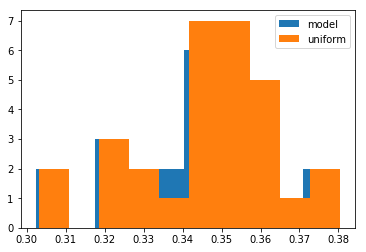

In [14]:
plt.hist(model_errs)
# plt.hist(random_errs)
plt.hist(uniform_errs)
# plt.legend(['model', 'random', 'uniform']);
plt.legend(['model', 'uniform'])

print('random: {} +- {}'.format(np.mean(random_errs), np.std(random_errs)))
print('uniform: {} +- {}'.format(np.mean(uniform_errs), np.std(uniform_errs)))
print('model: {} +- {}'.format(np.mean(model_errs), np.std(model_errs)));